<a href="https://colab.research.google.com/github/ashishpatel26/SRCNN_Step_by_Step/blob/main/SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Add
from keras.models import Model
import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

%matplotlib inline

In [2]:
shutil.unpack_archive('/content/train.zip', extract_dir=".")

In [3]:
def load_images(inputdir, inputpath, imagesize):
    imglist = []
    
    for i in range(len(inputpath)):
        img = cv2.imread(inputdir+inputpath[i], cv2.IMREAD_COLOR) 
        img=cv2.resize(img,(128,128))
        img = img[::-1] 
        imglist.append(img)
        
    return imglist

In [4]:
IMAGE_SIZE = 128

image_path = sorted(os.listdir("/content/train"))


image =load_images("/content/train/", image_path, IMAGE_SIZE)
 
image /= np.max(image)

image.shape

(90, 128, 128, 3)

In [5]:
label= np.zeros((90,128,128,3), np.float32)
for i in range(image.shape[0]):
    temp=cv2.resize(image[i,:,:,:],(64,64))
    temp=cv2.resize(temp,(128,128))
    label[i,:,:,:]=temp
label.shape

(90, 128, 128, 3)

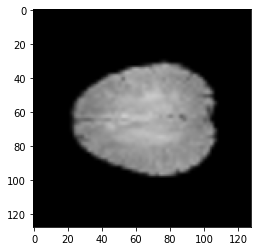

In [6]:
plt.imshow(label[0])

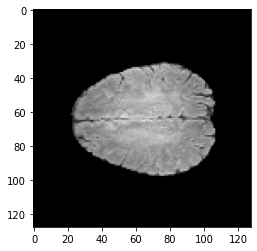

In [7]:
plt.imshow(image[0])

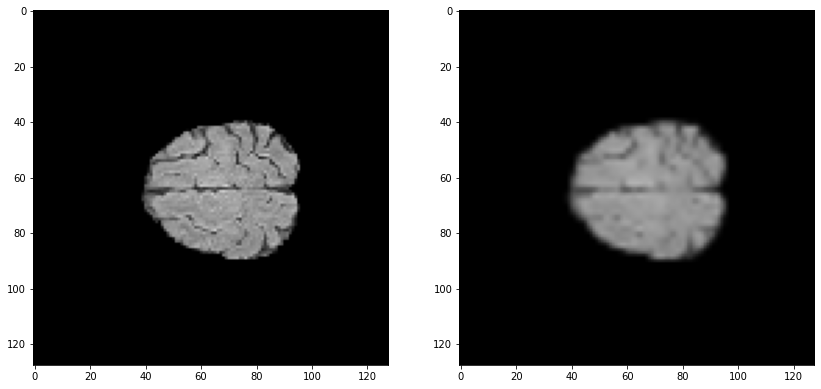

In [8]:
num = 20

plt.figure(figsize=(14, 7))

ax = plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image[num]))

ax = plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(label[num]))
plt.show()

In [9]:
def SRCNN():
    input_img = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
    
    enc1 = Conv2D(64,kernel_size=3,activation="relu",padding="same")(input_img)
    enc1 = Conv2D(64,kernel_size=3,activation="relu",padding="same")(enc1)
    down1 = MaxPooling2D(pool_size=2)(enc1)

    enc2 = Conv2D(128,kernel_size=3,activation="relu",padding="same")(down1)
    enc2 = Conv2D(128,kernel_size=3,activation="relu",padding="same")(enc2)
    down2 = MaxPooling2D(pool_size=2)(enc2)
    
    enc3 = Conv2D(256,kernel_size=3,activation="relu",padding="same")(down2)
    
    up3 = UpSampling2D(size=2)(enc3)
    dec3 = Conv2D(128,kernel_size=3,activation="relu",padding="same")(up3)
    dec3 = Conv2D(128,kernel_size=3,activation="relu",padding="same")(dec3)
    
    add2 = Add()([dec3,enc2])
    up2 = UpSampling2D(size=2)(add2)
    dec2 = Conv2D(64,kernel_size=3,activation="relu",padding="same")(up2)
    dec2 = Conv2D(64,kernel_size=3,activation="relu",padding="same")(dec2)
    
    add1 = Add()([dec2,enc1])
    dec1 = Conv2D(3,kernel_size=5,activation="linear",padding="same")(add1)
    
    model = Model(input_img,dec1)
    return model

model = SRCNN()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
initial_learningrate=2e-3
    
def lr_decay(epoch):
    if epoch < 500:
        return initial_learningrate
    else:
        return initial_learningrate * 0.99 ** epoch


def psnr(y_true,y_pred):
    return -10*K.log(K.mean(K.flatten((y_true-y_pred))**2))/np.log(10)

# Loss functtion
def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

model.compile(loss="mean_squared_error",optimizer=Adam(lr=initial_learningrate),metrics=[psnr, ssim_loss])

model.fit(label,image,epochs=200,batch_size=32,verbose=1,callbacks=[LearningRateScheduler(lr_decay,verbose=1)])

Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.002.
3/3 [==============================] - 36s 1s/step - loss: 0.0721 - psnr: 11.7347 - ssim_loss: 0.4780
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.002.
3/3 [==============================] - 0s 119ms/step - loss: 0.0345 - psnr: 14.6195 - ssim_loss: 0.6643
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.002.
3/3 [==============================] - 0s 120ms/step - loss: 0.0145 - psnr: 18.6727 - ssim_loss: 0.3138
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 0.002.
3/3 [==============================] - 0s 122ms/step - loss: 0.0047 - psnr: 23.2576 - ssim_loss: 0.4398
Epoch 5/200

Epoch 00005: LearningRateScheduler reducing learning rate to 0.002.
3/3 [==============================] - 0s 120ms/step - loss: 0.0031 - psnr: 25.1411 - ssim_loss: 0.7823
Epoch 6/200

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0

In [12]:
results = model.predict(image,verbose=1)

3/3 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


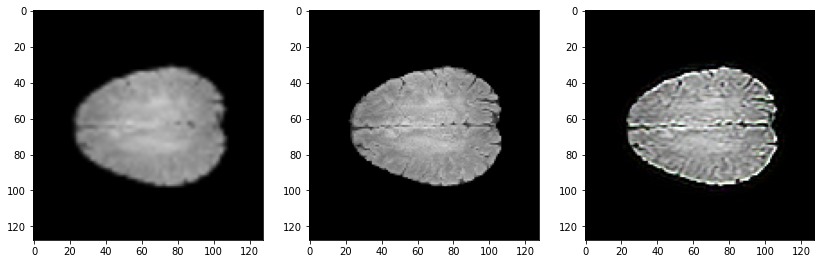

In [14]:
n = 0

plt.figure(figsize=(14, 7))

ax = plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(results[n]))

ax = plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(image[n]))

ax = plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(label[n]))
plt.show()